In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import optax

In [2]:
def mix(mus, sigmas):
    if len(mus) != len(sigmas):
        raise ValueError("mus and sigmas must have the same length")
    return lambda x: sum([stats.multivariate_normal.pdf(x, m, s)\
                        for m, s in zip(mus, sigmas)]) / len(mus)

# Laplace Approximation

In [3]:
def laplace_approximation(f, x=None, x0=None):
    if x0 is None:
        x0 = x[jnp.argmax(f(x))]
    A = -jax.hessian(lambda z: jnp.log(f(z)))(x0)
    if A.size > 1:
        return lambda y: stats.multivariate_normal.pdf(y, x0, jnp.linalg.inv(A))
    else:
        return lambda y: stats.norm.pdf(y, x0, 1/A)
                      

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


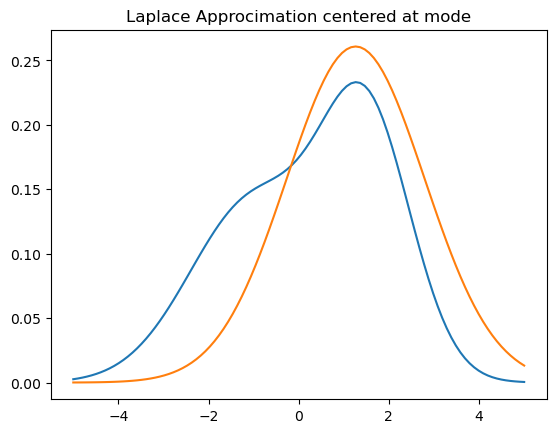

RMSE: 0.04747863


In [4]:
f = jax.jit(mix([-1.0, 1.5], [2, 1]))
x = jnp.linspace(-5, 5, 100)
g = laplace_approximation(f, x)

plt.plot(x, f(x))
plt.plot(x, g(x).flatten())
plt.title('Laplace Approcimation centered at mode')
plt.show()
print('RMSE:', jnp.mean((g(x) - f(x))**2)**.5)

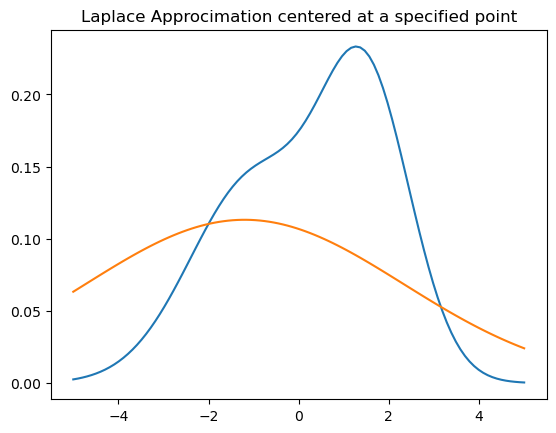

RMSE: 0.068877675


In [5]:
g = laplace_approximation(f, x0=-1.2)

plt.plot(x, f(x))
plt.plot(x, g(x).flatten())
plt.title('Laplace Approcimation centered at a specified point')
plt.show()
print('RMSE:', jnp.mean((g(x) - f(x))**2)**.5)

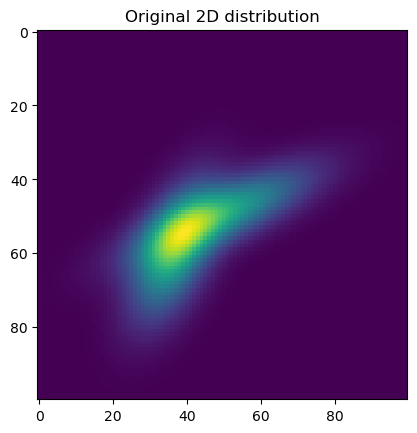

In [6]:
f = mix([jnp.array([0, 0]), 
         jnp.array([1, 1.3])], 
        [jnp.array([[.7, 1.0], [1.0, 2.5]]), 
         jnp.array([[1.5, .5], [.5, .6]])])
x = jnp.linspace(-5, 5, 100)
x = jnp.concatenate([jnp.repeat(x, len(x))[:,None], 
                       jnp.tile(x, len(x))[:,None]], axis=1)

y = f(x)
plt.imshow(y.reshape(100, 100)[:,::-1])
plt.title('Original 2D distribution')
plt.show()

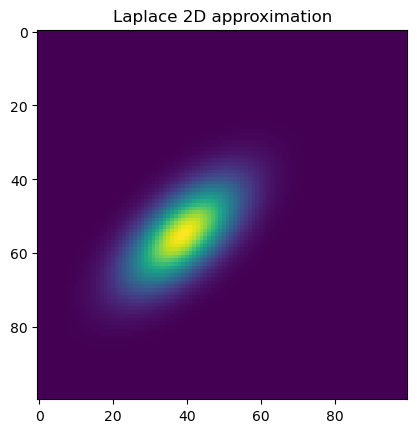

RMSE: 0.010735365


In [7]:
g = laplace_approximation(f, x)

plt.imshow(g(x).reshape(100, 100)[:,::-1])
plt.title('Laplace 2D approximation')
plt.show()

print('RMSE:', jnp.mean((g(x) - f(x))**2)**.5)

# Variational Inference

In [8]:
def kl(pzx, q, z):
    eps = 1e-6
    return -jnp.sum(q(z) * jnp.log((pzx(z) + eps) / (q(z) + eps)))

def variational_inference(pzx, q_gen, z, phi, n_iter=100):
    loss = lambda pars: kl(pzx, q_gen(pars), z)
    loss_val_grad = jax.jit(jax.value_and_grad(loss))
    optimiser = optax.adam(learning_rate=0.1)
    opt_state = optimiser.init(phi)

    for i in range(n_iter):
        kl_loss, grads = loss_val_grad(phi)
        updates, opt_state = optimiser.update(grads, opt_state)
        phi = optax.apply_updates(phi, updates)
    return q_gen(phi)

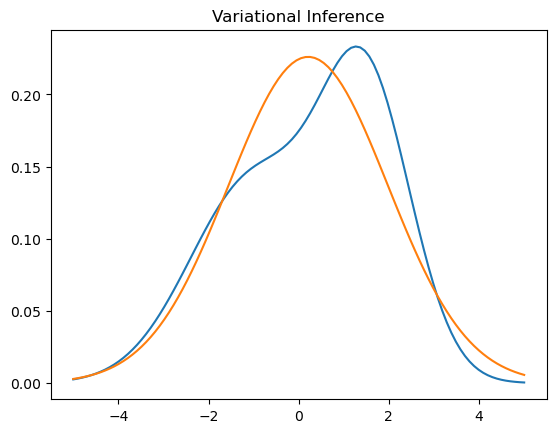

RMSE: 0.02690285


In [9]:
f = jax.jit(mix([-1.0, 1.5], [2, 1]))
x = jnp.linspace(-5, 5, 100)

q_gen = lambda pars: (lambda z: stats.norm.pdf(z, pars['mu'], pars['sigma']))
phi_0 = {'mu' : 1.0, 'sigma' : 1.0}
pzx = f
q = variational_inference(pzx, q_gen, x, phi_0, 300)

plt.plot(x, f(x))
plt.plot(x, q(x).flatten())

plt.title('Variational Inference')
plt.show()
print('RMSE:', jnp.mean((q(x) - f(x))**2)**.5)

# Expectation Propagation

In [10]:
def moment_matching(p, z):
    if len(x.shape) == 1:
        mean = (z*p(z)).sum() / p(z).sum()
        std = ((z-mean)**2 * p(z)).sum() / p(z).sum()
        return lambda x: stats.multivariate_normal.pdf(x, mean, std)
    elif len(x.shape) == 2:
        raise NotImplementedError('multidim moment matching not implemented')
    else:
        raise ValueError()

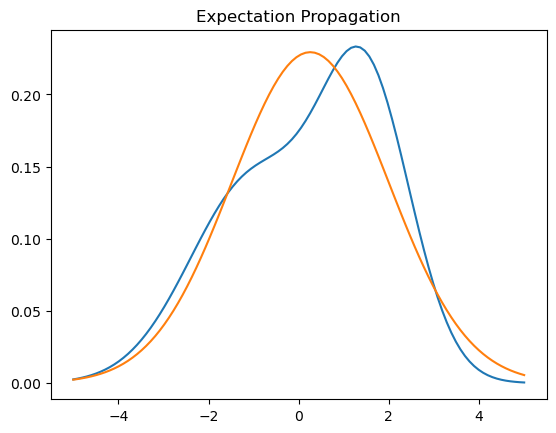

RMSE: 0.026358502


In [11]:
f = jax.jit(mix([-1.0, 1.5], [2, 1]))
x = jnp.linspace(-5, 5, 100)

q = moment_matching(f, x)

plt.plot(x, f(x))
plt.plot(x, q(x).flatten())

plt.title('Expectation Propagation')
plt.show()
print('RMSE:', jnp.mean((q(x) - f(x))**2)**.5)

# Comparison

In [12]:
x = jnp.linspace(-5, 5, 100)
q_gen = lambda pars: (lambda z: stats.norm.pdf(z, pars['mu'], pars['sigma']))
phi_0 = {'mu' : 0.5, 'sigma' : 1.0}

f1 = jax.jit(mix([-1.0, 1.5], [2, 1]))
f2 = jax.jit(mix([-1.0, 2], [3, 0.5]))
f3 = lambda x: stats.beta.pdf(x, 0.3, 0.9)
f4 = lambda x: stats.beta.pdf(x, 0.4, 0.5)

fs = [f1, f2, f3, f4]

m1 = laplace_approximation
m2 = lambda f, x: variational_inference(f, q_gen, x, phi_0, 300)
m3 = moment_matching

ms = [m1, m2, m3]
names = ['Laplace Approximation', 
         'Variational Inference', 
         'Expectation Propagation']

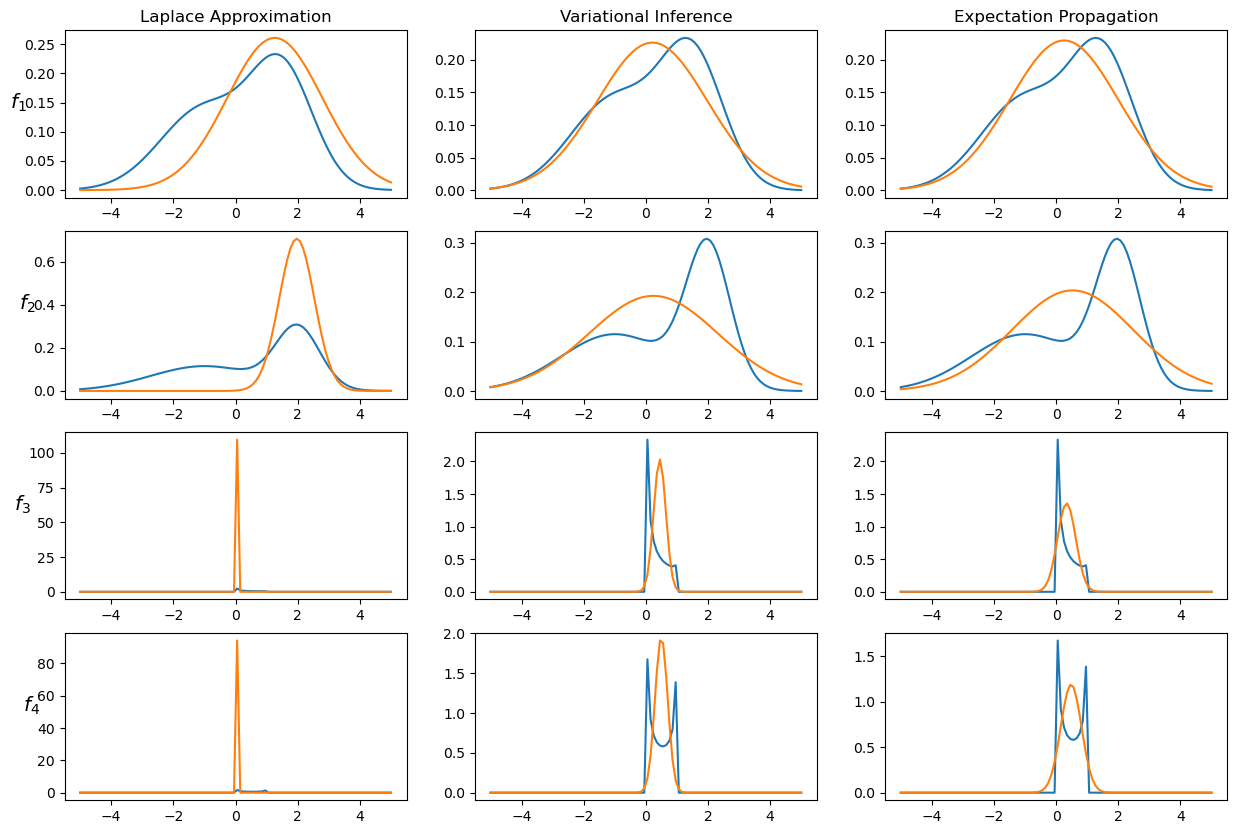

In [13]:
_, axs = plt.subplots(len(fs), len(ms), figsize=(15,10))

for i, func in enumerate(fs):
    for j, (method, name) in enumerate(zip(ms, names)):
        axs[i, j].plot(x, func(x)) 
        axs[i, j].plot(x, method(func, x)(x).flatten())
        axs[0, j].set_title(name)
        axs[i, 0].set_ylabel(f'$f_{i+1}$', rotation=0, size='x-large')